## Analyzing the trajectory

In [20]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

In [42]:
import sys
sys.path.append("/g/g92/dskoda/prj/dskrc/python/inits")

from plotting import *
plt.rcParams['figure.dpi'] = 150
plt.style.use("paper")

In [19]:
from ase.io import Trajectory
from ase.geometry.analysis import Analysis

In [2]:
def get_edge_list(atoms):
    an = Analysis(atoms)
    edge_list = []
    for i, bonds in enumerate(an.all_bonds[0]):
        for j in bonds:
            edge_list.append([i, j])

    return np.array(edge_list)

def get_distances(atoms, edge_list=None):
    dm = atoms.get_all_distances()
    if edge_list is None:
        return dm
    
    return dm[edge_list[:, 0], edge_list[:, 1]]    

In [3]:
def get_explosion_index(traj):
    edges = get_edge_list(traj[0])
    
    max_dists = np.array([
        get_distances(at, edges).max()
        for at in traj
    ])
    index = np.argwhere(max_dists > 2).flat
    if len(index) == 0:
        return len(traj)
    
    return index[0]

## Analyzing all trajectories

In [4]:
import os
import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
PATHS = [f"/usr/WS2/dsk-jv/nequip/md/runs-{f}" for f in ["3", "3-2", "3-3"]]

traj_files = sorted([
    os.path.join(_path, f)
    for _path in PATHS
    for f in os.listdir(_path)
    if f.endswith(".json")
])

In [6]:
results = []

for _json in tqdm.tqdm(traj_files):
    with open(_json, "r") as f:
        traj = json.load(f)
        
    model, i = _json.split("/")[-1].replace(".json", "").split("-")
    traj["model"] = model
    traj["num"] = int(i)

    results.append(traj)

100%|██████████| 390/390 [00:01<00:00, 316.39it/s]


In [7]:
df = pd.DataFrame(results)

In [17]:
good_mds = [
    f.replace("json", "traj")
    for name in df.loc[df.explosion > 6000].name
    for f in traj_files
    if name in f
]

In [28]:
_trajdf = []

for f in tqdm.tqdm(good_mds):
    name = f.split("/")[-1].replace(".traj", "")
    model, _ = name.split("-")
    traj = Trajectory(f)
    
    for i, at in enumerate(traj):
        _trajdf.append({
            "name": name,
            "model": model,
            "i": i,
            "temperature": at.get_temperature(),
        })

tdf = pd.DataFrame(_trajdf)

100%|██████████| 36/36 [01:53<00:00,  3.14s/it]


In [33]:
avgdf = tdf.groupby("i")["temperature"].mean()
stddf = tdf.groupby("i")["temperature"].std()

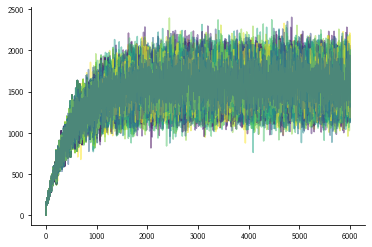

In [31]:
fig, ax = plt.subplots()

norm = plt.Normalize(0, 1)

for name, _df in tdf.groupby("name"):
    ax.plot(
        _df["i"],
        _df["temperature"],
        color=cm.viridis(norm(np.random.sample())),
        alpha=0.5,
    )
    
plt.show()

In [53]:
len(tdf.name.unique())

36

webf NOT subset; don't know how to subset; dropped


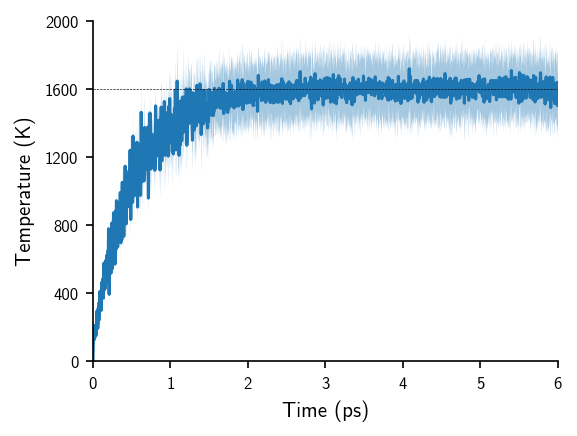

In [51]:
fig, ax = plt.subplots(figsize=(4, 3))

_x = avgdf.index / 1000

ax.plot(
    _x,
    avgdf.values,
#     color='k'
)

ax.fill_between(
    _x,
    avgdf.values - stddf.values,
    avgdf.values + stddf.values,
    alpha=0.4,
)

ax.plot(
    [_x.min(), _x.max()],
    [1600, 1600],
    color='k',
    linestyle="--",
    linewidth=0.3,
)

ax.set_ylabel("Temperature (K)")
ax.set_xlabel("Time (ps)")

ax.set_xlim(0, 6)
ax.set_ylim(0, 2000)
ax.set_yticks([0, 400, 800, 1200, 1600, 2000])

fig.savefig("04_si/md_temperature.pdf", bbox_inches="tight", transparent=True)
plt.show()